In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading the dataset


In [ ]:

with open('/content/drive/MyDrive/ocr/datax.pickle', 'rb') as f:
  images = pickle.load(f)
with open('/content/drive/MyDrive/ocr/datay.pickle', 'rb') as f:
  labels = pickle.load(f)



print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))

batch_size = 1





downsample_factor = 4


max_length = max([len(label) for label in labels])


characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)




img_width = 250
img_height = 50



max_length = max([len(label) for label in labels])

Number of images found:  604
Number of labels found:  604
Number of images found:  604
Number of labels found:  604
Number of unique characters:  31
Characters present:  {'D', '7', '0', 'X', 'F', 'K', 'C', 'M', 'T', '2', 'P', 'E', 'R', '5', '6', 'H', '4', '3', '1', 'S', '8', 'G', 'I', 'A', 'J', 'V', 'N', 'Z', '9', 'B', 'L'}


Preprocessing


In [ ]:
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), mask_token=None
)


num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)





def encode_single_sample(img, label):

    img = img/255.0
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.transpose(img, perm=[1, 0, 2])

    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))

    return {"image": img, "label": label}

In [ ]:
Train test split


In [ ]:
len_train = int(0.8 * len(images))

In [ ]:
len_train

483

In [ ]:
x_train, y_train = images[:len_train], labels[:len_train]
x_valid, y_valid = images[len_train:], labels[len_train:]

In [ ]:
y_train.shape

(483,)

building the dataset pipeline with tf.data.Dataset


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(        encode_single_sample,    ).batch(batch_size)
    


validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset =  validation_dataset.map( encode_single_sample,).batch(batch_size)

Visualizing the dataset


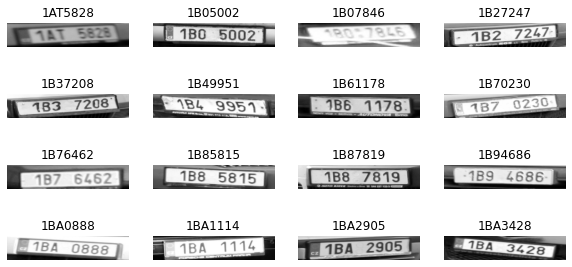

In [ ]:

_, ax = plt.subplots(4, 4, figsize=(10, 5))
# for batch in train_dataset.take(1):
#     images = batch["image"]
#     labels = batch["label"]
for i in range(16):
    img = (x_train[i] ).astype("uint8")
    # label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
    label = y_train[i]
    ax[i // 4, i % 4].imshow(img[:, :, 0], cmap="gray")
    ax[i // 4, i % 4].set_title(label)
    ax[i // 4, i % 4].axis("off")
plt.show()

Model building

In [ ]:

class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):

        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred


def build_model():
   
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")


    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)


    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)


    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

 
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)


    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    output = CTCLayer(name="ctc_loss")(labels, x)


    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
 
    opt = keras.optimizers.Adam(5e-4)

    model.compile(optimizer=opt)
    return model



model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 250, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 250, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 125, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 125, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

In [ ]:

# early_stopping_patience = 10
# Add early stopping
# early_stopping = keras.callbacks.EarlyStopping(
#     monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
# )

# Train the model
for i in range(600):
  print(i)
  history = model.fit(
      train_dataset,
      validation_data=validation_dataset,
      epochs=1
      
      
      # callbacks=[early_stopping],
  )

0
483/483 [==============================] - 8s 17ms/step - loss: 18.1968 - val_loss: 18.3887
1
483/483 [==============================] - 8s 17ms/step - loss: 17.8666 - val_loss: 18.4051
2
483/483 [==============================] - 8s 17ms/step - loss: 17.7764 - val_loss: 18.6438
3
483/483 [==============================] - 8s 17ms/step - loss: 17.6083 - val_loss: 18.4272
4
483/483 [==============================] - 8s 17ms/step - loss: 17.5629 - val_loss: 18.8202
5
483/483 [==============================] - 8s 17ms/step - loss: 17.6796 - val_loss: 18.3919
6
483/483 [==============================] - 8s 17ms/step - loss: 17.6103 - val_loss: 18.3024
7
483/483 [==============================] - 8s 17ms/step - loss: 17.5482 - val_loss: 18.4084
8
483/483 [==============================] - 8s 17ms/step - loss: 17.5633 - val_loss: 18.2501
9
483/483 [==============================] - 8s 17ms/step - loss: 17.5086 - val_loss: 18.1988
10
483/483 [==============================] - 8s 17ms/step -

KeyboardInterrupt: ignored

Prediction


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 250, 50, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 250, 50, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 125, 25, 32)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 125, 25, 64)       18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 62, 12, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 62, 768)           0         
_________________________________________________________________
dense1 (Dense)               (None, 62, 64)            4921

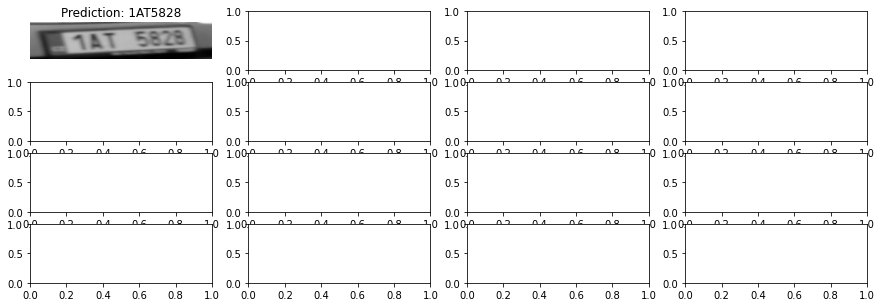

In [ ]:

prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()


def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
   
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]

    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text



for batch in train_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [ ]:

prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()


def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    
    
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text



true_text = []
pred_text = []
img = []

while len(true_text) != len(x_train):
  for batch in train_dataset.take(len(train_dataset)):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    img.append(batch_images)

    orig_texts = []

    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)
        true_text.append(label)
        pred_text.append(pred_texts)
        


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 250, 50, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 250, 50, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 125, 25, 32)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 125, 25, 64)       18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 62, 12, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 62, 768)           0         
_________________________________________________________________
dense1 (Dense)               (None, 62, 64)            492

In [ ]:
batch['image'].shape

TensorShape([1, 250, 50, 1])

In [ ]:
true_text_array = np.array(true_text)
pred_text_array = np.array(pred_text)

In [ ]:
true_text_array.shape

(121,)

In [ ]:
img = np.asarray(img)
img.shape

(483, 1, 250, 50, 1)

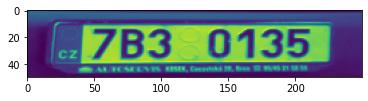

In [ ]:
img1 = np.reshape(img,(121,250,50))
plt.imshow(img1[0].T)

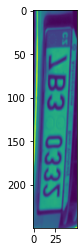

In [ ]:
plt.imshow(img[1][0,:,:,0])

In [ ]:
c = 0
for x in pred_text:
  print(x)
  c +=1 

['9B90732']
['7B30382']
['6B00198']
['3AI3806']
['1B11448']
['3B60332']
['8B36198']
['7B31775']
['2B77185']
['8B84157']
['7B66604']
['5B50830']
['5Z43987']
['6B58746']
['2B26695']
['7B61923']
['7B63766']
['8B44389']
['6B66556']
['1B17195']
['7B71487']
['5B89922']
['4B68905']
['8B59090']
['5B22511']
['9B6973[UNK]']
['6B90398']
['7B61342']
['2ZN2165']
['3B38333']
['8B02123']
['9B1375G']
['8B10185']
['3B70992']
['3B32445']
['7B11175']
['1B27295']
['8B22459']
['5B28858']
['8B27398']
['8B23390']
['8B64552']
['1B64644']
['8B64192']
['8B66516']
['9BI1177']
['6B70555']
['3B00882']
['8B68385']
['2B79995']
['9B33295']
['8BA1016']
['8B61442']
['8B88881']
['7B64142']
['8B91698']
['8T32297']
['B5378[UNK][UNK]']
['8C48022']
['9T19432']
['2B20774']
['4B16905']
['9B13775']
['9B13376']
['7B11854']
['9B14541']
['9B29274']
['9B30035']
['6B23790']
['9B92992']
['9B93905']
['9B38398']
['1B43105']
['1BC2805']
['9B16513']
['9B46988']
['4B97184']
['9B52145']
['9B51117']
['9BA8829']
['3B89490']
['9B64094']
['1B

In [ ]:
np.save('/content/drive/MyDrive/ocr/train_pred.npy',pred_text)

Prediction on train dataset............Results on test dataset were not good. Model was overfitted. More training examples would helped the model to get better generalization results. Could have done brightness augmentation on the images which had improved the results

```
# This is formatted as code
```



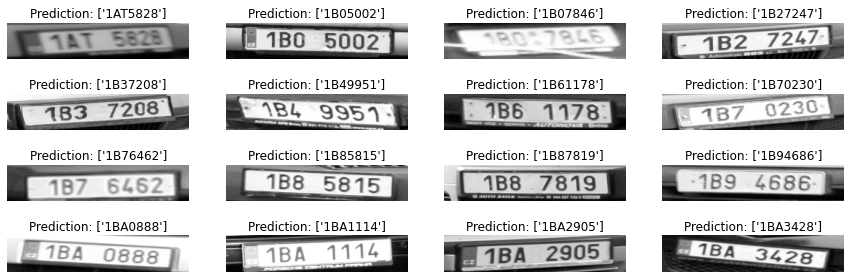

In [ ]:
_, ax = plt.subplots(4, 4, figsize=(15, 5))
for i in range(16):
    # img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
    img = x_train[i][:,:,0]
    # label = y_valid[i]
    title = f"Prediction: {pred_text[i]}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")
plt.show()

Out of 121 validation images only 8 were correctly recongized. An obvious case of overfitting

In [ ]:
np.sum(true_text_array == pred_text_array)

8